In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!nvidia-smi



import torch
print(torch.cuda.is_available())


import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

Fri May 24 04:26:35 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
import pandas as pd

# Load the dataset
file_path = '/content/drive/MyDrive/simran/Fraud_dataset1.csv'  # Change to your dataset path
df = pd.read_csv(file_path)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Separate rows where 'isFraud' column equals 0 and 1
df_isFraud_0 = df[df['isFraud'] == 0]
df_isFraud_1 = df[df['isFraud'] == 1]

# Take a sample of rows where 'isFraud' column equals 0, same number as where 'isFraud' equals 1
df_isFraud_0_balanced = df_isFraud_0.sample(n=len(df_isFraud_1))

# Concatenate the balanced dataframes
balanced_df = pd.concat([df_isFraud_0_balanced, df_isFraud_1])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

balanced_df.count()

step              232
type              232
amount            232
nameOrig          232
oldbalanceOrg     232
newbalanceOrig    232
nameDest          232
oldbalanceDest    232
newbalanceDest    232
isFraud           232
isFlaggedFraud    232
dtype: int64

In [5]:
# Feature engineering
df['errorBalanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

# Encode categorical data
df['type'] = df['type'].astype('category').cat.codes

print(df.head())

   step  type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1     3   9839.64  C1231006815       170136.0       160296.36   
1     1     3   1864.28  C1666544295        21249.0        19384.72   
2     1     4    181.00  C1305486145          181.0            0.00   
3     1     1    181.00   C840083671          181.0            0.00   
4     1     3  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  \
0  M1979787155             0.0             0.0        0               0   
1  M2044282225             0.0             0.0        0               0   
2   C553264065             0.0             0.0        1               0   
3    C38997010         21182.0             0.0        1               0   
4  M1230701703             0.0             0.0        0               0   

   errorBalanceOrig  errorBalanceDest  
0      1.455192e-11           9839.64  
1     -1.136868e-12           1864.28  
2 

In [6]:
!pip uninstall imbalanced-learn
!pip install imbalanced-learn==0.8.0

Found existing installation: imbalanced-learn 0.10.1
Uninstalling imbalanced-learn-0.10.1:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/imbalanced_learn-0.10.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/imblearn/*
Proceed (Y/n)? y
  Successfully uninstalled imbalanced-learn-0.10.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.5/206.5 kB 7.6 MB/s eta 0:00:00


In [8]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Assuming 'df' is your original DataFrame
X = df.drop('isFraud', axis=1)  # Features
y = df['isFraud']  # Target

# Balancing the dataset by under-sampling the majority class
rus = RandomUnderSampler(random_state=42)
X_balanced, y_balanced = rus.fit_resample(X, y)

# Check the shape of the resampled data
print("Shape of X_balanced:", X_balanced.shape)
print("Shape of y_balanced:", y_balanced.shape)

# Ensure columns are correct
print("Columns in X_balanced:", X_balanced.columns)  # This line will throw an error if X_balanced is a numpy array

# Recreate DataFrame from the balanced data
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['isFraud'] = y_balanced

# Print the first few rows to verify the data
print(df_balanced.head())


Shape of X_balanced: (232, 12)
Shape of y_balanced: (232,)
Columns in X_balanced: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFlaggedFraud',
       'errorBalanceOrig', 'errorBalanceDest'],
      dtype='object')
   step  type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     9     3    3621.22   C800843950           0.00            0.00   
1     9     3   25829.29   C600469588      649628.43       623799.14   
2     8     3    5024.64   C123786424           0.00            0.00   
3    10     0  234310.40  C1026849047       74923.00       309233.40   
4     9     3   16525.92   C114330451           0.00            0.00   

      nameDest  oldbalanceDest  newbalanceDest  isFlaggedFraud  \
0   M215403083            0.00            0.00               0   
1  M1627608209            0.00            0.00               0   
2   M479647126            0.00            0.00               0  

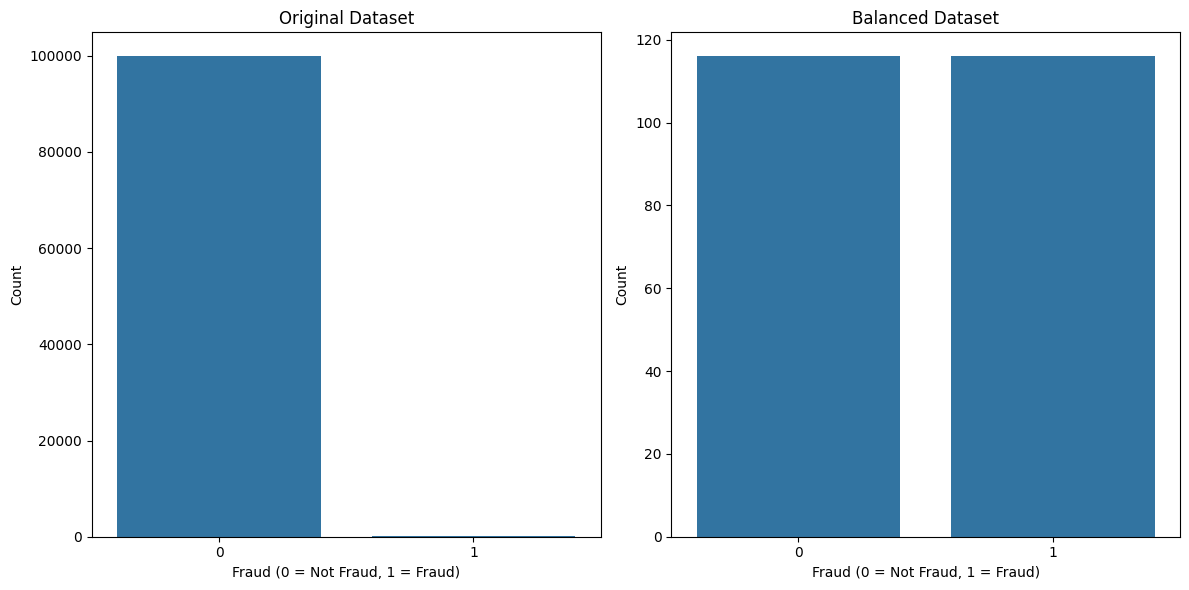

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is the original dataset and balanced_df is the balanced dataset

# Set up the matplotlib figure
plt.figure(figsize=(12, 6))

# Plot the original dataset
plt.subplot(1, 2, 1)
sns.countplot(x='isFraud', data=df)
plt.title('Original Dataset')
plt.xlabel('Fraud (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Count')

# Plot the balanced dataset
plt.subplot(1, 2, 2)
sns.countplot(x='isFraud', data=balanced_df)
plt.title('Balanced Dataset')
plt.xlabel('Fraud (0 = Not Fraud, 1 = Fraud)')
plt.ylabel('Count')

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
# Function to convert each row to LLaMA-2 format and more checking
def format_row(row):
    text = f"<s>[INST] In this task, you will be performing a classification exercise aimed at identifying whether the following transaction is fraudulent. Consider the transaction details: Type: {row['type']}, Amount: {row['amount']}, Origin Account: {row['nameOrig']}, Original Balance Before: {row['oldbalanceOrg']}, Original Balance After: {row['newbalanceOrig']}, Destination Account: {row['nameDest']}, Destination Balance Before: {row['oldbalanceDest']}, Destination Balance After: {row['newbalanceDest']} [/INST]"
    label = "fraud" if row['isFraud'] else "not_fraud"
    return f"{text} {label} <s>"

# Apply the function to each row and add to a new column
df_balanced['LLaMA2_Input'] = df_balanced.apply(format_row, axis=1)



# Example output
print(df_balanced['LLaMA2_Input'][0])


# Save the DataFrame with the formatted LLaMA-2 input to a CSV file
df_balanced.to_csv('/content/drive/MyDrive/simran/data/train_dataset.csv', index=False)

<s>[INST] In this task, you will be performing a classification exercise aimed at identifying whether the following transaction is fraudulent. Consider the transaction details: Type: 3, Amount: 3621.22, Origin Account: C800843950, Original Balance Before: 0.0, Original Balance After: 0.0, Destination Account: M215403083, Destination Balance Before: 0.0, Destination Balance After: 0.0 [/INST] not_fraud <s>


In [11]:
b_df=pd.read_csv('/content/drive/MyDrive/simran/data/train_dataset.csv')
b_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud,errorBalanceOrig,errorBalanceDest,isFraud,LLaMA2_Input
0,9,3,3621.22,C800843950,0.00,0.00,M215403083,0.00,0.00,0,-3.621220e+03,3621.22,0,"<s>[INST] In this task, you will be performing..."
1,9,3,25829.29,C600469588,649628.43,623799.14,M1627608209,0.00,0.00,0,3.637979e-11,25829.29,0,"<s>[INST] In this task, you will be performing..."
2,8,3,5024.64,C123786424,0.00,0.00,M479647126,0.00,0.00,0,-5.024640e+03,5024.64,0,"<s>[INST] In this task, you will be performing..."
3,10,0,234310.40,C1026849047,74923.00,309233.40,C442364016,2586304.21,2403341.04,0,-4.686208e+05,417273.57,0,"<s>[INST] In this task, you will be performing..."
4,9,3,16525.92,C114330451,0.00,0.00,M233535936,0.00,0.00,0,-1.652592e+04,16525.92,0,"<s>[INST] In this task, you will be performing..."


In [12]:
!pip install autotrain-advanced

In [13]:
!pip install huggingface_hub

In [14]:
from huggingface_hub import notebook_login

notebook_login()

In [15]:
!autotrain setup

INFO     | 2024-05-24 04:29:20 | autotrain.cli.run_setup:run:43 - Installing latest xformers
INFO     | 2024-05-24 04:29:20 | autotrain.cli.run_setup:run:45 - Successfully installed latest xformers


In [16]:
!autotrain llm --help

usage: autotrain <command> [<args>] llm [-h] [--train] [--deploy] [--inference]
                                        [--username USERNAME]
                                        [--backend {spaces-a10g-large,spaces-a10g-small,spaces-a100-large,spaces-t4-medium,spaces-t4-small,spaces-cpu-upgrade,spaces-cpu-basic,spaces-l4x1,spaces-l4x4,spaces-a10g-largex2,spaces-a10g-largex4,dgx-a100,dgx-2a100,dgx-4a100,dgx-8a100,ep-aws-useast1-s,ep-aws-useast1-m,ep-aws-useast1-l,ep-aws-useast1-xl,ep-aws-useast1-2xl,ep-aws-useast1-4xl,ep-aws-useast1-8xl,nvcf-l40sx1,nvcf-h100x1,nvcf-h100x2,nvcf-h100x4,nvcf-h100x8,local-ui,local,local-cli}]
                                        [--token TOKEN] [--push-to-hub] --model MODEL
                                        --project-name PROJECT_NAME [--data-path DATA_PATH]
                                        [--train-split TRAIN_SPLIT] [--valid-split VALID_SPLIT]
                                        [--batch-size BATCH_SIZE] [--seed SEED] [--epochs EPO

In [17]:
model = 'meta-llama/Llama-2-7b-chat-hf'

In [18]:
!autotrain llm --train --project-name neoj4 --model meta-llama/Llama-2-7b-chat-hf --data-path '/content/drive/MyDrive/simran/data' --mixed_precision fp16 --text-column LLaMA2_Input --use-peft --quantization int4 --lr 2e-4 --train-batch-size 10 --epochs 3 --trainer sft --model-max-length 512

INFO     | 2024-05-24 04:30:50 | autotrain.cli.run_llm:run:344 - Running LLM
WARNING  | 2024-05-24 04:30:50 | autotrain.trainers.common:__init__:180 - Parameters supplied but not used: backend, deploy, inference, func, config, train, version
INFO     | 2024-05-24 04:30:50 | autotrain.backends.local:create:8 - Starting local training...
INFO     | 2024-05-24 04:30:50 | autotrain.commands:launch_command:372 - ['accelerate', 'launch', '--num_machines', '1', '--num_processes', '1', '--mixed_precision', 'fp16', '-m', 'autotrain.trainers.clm', '--training_config', 'neoj4/training_params.json']
INFO     | 2024-05-24 04:30:50 | autotrain.commands:launch_command:373 - {'model': 'meta-llama/Llama-2-7b-chat-hf', 'project_name': 'neoj4', 'data_path': '/content/drive/MyDrive/simran/data', 'train_split': 'train', 'valid_split': None, 'add_eos_token': False, 'block_size': -1, 'model_max_length': 512, 'padding': None, 'trainer': 'sft', 'use_flash_attention_2': False, 'log': 'none', 'disable_gradient_c

In [23]:
!pip install transformers

In [26]:
# Define the directory path
output_dir = "/content/drive/MyDrive/simran/Graph/Model"

# Check if the files are saved
import os

if os.path.exists(output_dir):
    print("Files in the output directory:")
    for filename in os.listdir(output_dir):
        print(filename)
else:
    print(f"The directory {output_dir} does not exist.")

Files in the output directory:
config.json
added_tokens.json
model.safetensors
tokenizer_config.json
spiece.model
special_tokens_map.json
generation_config.json
